# 7. Prediction on Merchant Fruad Prob

In [1]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
transaction = pd.read_parquet('../data/curated/transaction/transaction_wcf_after_prediction.parquet')
merchant_fraud = pd.read_csv('../data/tables/merchant_fraud_probability.csv')

Now we have whole transaction with consumer fruad prob, for sure we want to figure out the connection between transaction features(including consumer fruad prob) and merchant fruad prob. As ranking system will be merchant based.

5:5 separation for 2-way classification('safe' and 'risky') was conducted to achieve a tolerant classification, considering the very limited amount fraud data we have for merchants.

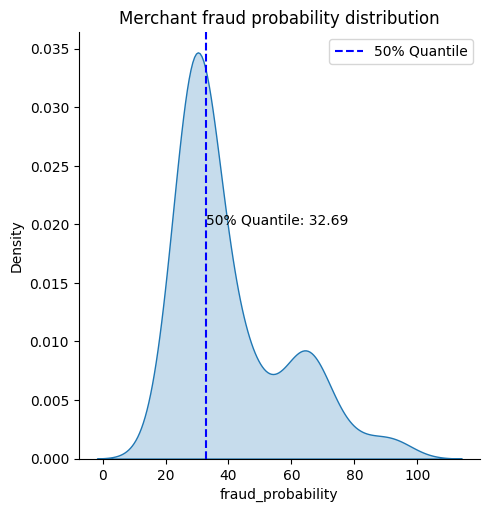

In [3]:
# draw merchant fraud probability distribution
sns.displot(merchant_fraud, x="fraud_probability", kind="kde", fill=True)
plt.title("Merchant fraud probability distribution")

# 50 quantile
quantile_50 = stats.scoreatpercentile(merchant_fraud['fraud_probability'], 50)
plt.axvline(x=quantile_50, color='blue', linestyle='--', label='50% Quantile')
plt.text(quantile_50 + 0.02, 0.02, f'50% Quantile: {quantile_50:.2f}', color='black', fontsize=10)

plt.legend()
plt.show()

## 7.1 Preprocessing

In [4]:
# encode merchant fraud probability to safe and risky by 50% quantile
merchant_fraud['fraud_probability'] = merchant_fraud['fraud_probability'].apply(lambda x: 'safe' if x < quantile_50 else 'risky')
merchant_fraud = merchant_fraud.rename(columns={'fraud_probability': 'risk_level'})

merchant_fraud

,merchant_abn,order_datetime,risk_level
0,19492220327,2021-11-28,risky
1,31334588839,2021-10-02,risky
2,19492220327,2021-12-22,risky
3,82999039227,2021-12-19,risky
4,90918180829,2021-09-02,risky
...,...,...,...
109,80089686333,2021-09-01,risky
110,83220249221,2021-11-27,risky
111,85482742429,2021-11-27,risky
112,11470993597,2021-09-28,risky


In [5]:
# count number of each risk level
merchant_fraud.groupby('risk_level').count()

,merchant_abn,order_datetime
risk_level,,
risky,57,57
safe,57,57


In [6]:
# encode risk level to 1, 2
merchant_fraud['risk_level'] = merchant_fraud['risk_level'].apply(lambda x: 1 if x == 'safe' else 2)

In [7]:
# merge transaction and merchant fraud probability on merchant_abn and order_datetime
transaction = transaction.merge(merchant_fraud, how='left', on=['merchant_abn', 'order_datetime'])
transaction

,user_id,merchant_abn,dollar_value,order_datetime,state,postcode,gender,revenue_level,take_rate,area,consumer_fraud_probability,risk_level
0,21989,31334588839,14080.096388,2021-02-28,VIC,3818,Undisclosed,b,4.22,antique,fraud,NaN
1,21989,14430838529,74.674454,2021-02-28,VIC,3818,Undisclosed,c,2.03,telecom,fraud,NaN
2,4144,45629217853,3.167339,2021-02-28,NSW,2736,Male,a,6.98,gift,safe,NaN
3,4351,64203420245,49.474965,2021-02-28,NSW,2340,Female,c,2.86,tent,unsure,NaN
4,4952,21439773999,76.071035,2021-02-28,NSW,1234,Male,a,6.10,telecom,safe,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
13588848,11135,49891706470,24.174809,2022-10-26,NSW,2013,Female,a,5.80,tent,safe,NaN
13588849,11136,24852446429,5.384811,2022-10-26,QLD,4707,Male,c,2.94,housekeeping,safe,NaN
13588850,11136,63685007785,48.129887,2022-10-26,QLD,4707,Male,e,0.38,telecom,safe,NaN
13588851,11137,85502310765,4.768752,2022-10-26,VIC,3413,Male,d,0.84,computer,safe,NaN


In [8]:
# check null values
transaction.isnull().sum()

user_id                              0
merchant_abn                         0
dollar_value                         0
order_datetime                       0
state                                0
postcode                             0
gender                               0
revenue_level                        0
take_rate                            0
area                                 0
consumer_fraud_probability           0
risk_level                    13584852
dtype: int64

In [9]:
# encoding 'revenue_level'
transaction['revenue_level'] = transaction['revenue_level'].astype('category')
transaction['revenue_level'] = transaction['revenue_level'].cat.codes

# one-hot encoding 'area'
transaction = pd.get_dummies(transaction, columns=['area'])

transaction

,user_id,merchant_abn,dollar_value,order_datetime,state,postcode,gender,revenue_level,take_rate,consumer_fraud_probability,...,area_housekeeping,area_jewelry,area_motor,area_music,area_optician,area_shoe,area_stationery,area_telecom,area_tent,area_toy
0,21989,31334588839,14080.096388,2021-02-28,VIC,3818,Undisclosed,1,4.22,fraud,...,0,0,0,0,0,0,0,0,0,0
1,21989,14430838529,74.674454,2021-02-28,VIC,3818,Undisclosed,2,2.03,fraud,...,0,0,0,0,0,0,0,1,0,0
2,4144,45629217853,3.167339,2021-02-28,NSW,2736,Male,0,6.98,safe,...,0,0,0,0,0,0,0,0,0,0
3,4351,64203420245,49.474965,2021-02-28,NSW,2340,Female,2,2.86,unsure,...,0,0,0,0,0,0,0,0,1,0
4,4952,21439773999,76.071035,2021-02-28,NSW,1234,Male,0,6.10,safe,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13588848,11135,49891706470,24.174809,2022-10-26,NSW,2013,Female,0,5.80,safe,...,0,0,0,0,0,0,0,0,1,0
13588849,11136,24852446429,5.384811,2022-10-26,QLD,4707,Male,2,2.94,safe,...,1,0,0,0,0,0,0,0,0,0
13588850,11136,63685007785,48.129887,2022-10-26,QLD,4707,Male,4,0.38,safe,...,0,0,0,0,0,0,0,1,0,0
13588851,11137,85502310765,4.768752,2022-10-26,VIC,3413,Male,3,0.84,safe,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# split data
train = transaction.dropna()
predict = transaction[transaction['risk_level'].isnull()]

predict

,user_id,merchant_abn,dollar_value,order_datetime,state,postcode,gender,revenue_level,take_rate,consumer_fraud_probability,...,area_housekeeping,area_jewelry,area_motor,area_music,area_optician,area_shoe,area_stationery,area_telecom,area_tent,area_toy
0,21989,31334588839,14080.096388,2021-02-28,VIC,3818,Undisclosed,1,4.22,fraud,...,0,0,0,0,0,0,0,0,0,0
1,21989,14430838529,74.674454,2021-02-28,VIC,3818,Undisclosed,2,2.03,fraud,...,0,0,0,0,0,0,0,1,0,0
2,4144,45629217853,3.167339,2021-02-28,NSW,2736,Male,0,6.98,safe,...,0,0,0,0,0,0,0,0,0,0
3,4351,64203420245,49.474965,2021-02-28,NSW,2340,Female,2,2.86,unsure,...,0,0,0,0,0,0,0,0,1,0
4,4952,21439773999,76.071035,2021-02-28,NSW,1234,Male,0,6.10,safe,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13588848,11135,49891706470,24.174809,2022-10-26,NSW,2013,Female,0,5.80,safe,...,0,0,0,0,0,0,0,0,1,0
13588849,11136,24852446429,5.384811,2022-10-26,QLD,4707,Male,2,2.94,safe,...,1,0,0,0,0,0,0,0,0,0
13588850,11136,63685007785,48.129887,2022-10-26,QLD,4707,Male,4,0.38,safe,...,0,0,0,0,0,0,0,1,0,0
13588851,11137,85502310765,4.768752,2022-10-26,VIC,3413,Male,3,0.84,safe,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# reset train index
train = train.reset_index(drop=True)
train

,user_id,merchant_abn,dollar_value,order_datetime,state,postcode,gender,revenue_level,take_rate,consumer_fraud_probability,...,area_housekeeping,area_jewelry,area_motor,area_music,area_optician,area_shoe,area_stationery,area_telecom,area_tent,area_toy
0,19453,83199298021,13887.358607,2021-03-25,NSW,1835,Female,1,4.82,fraud,...,0,0,0,0,0,0,0,0,0,0
1,2550,83199298021,37808.999083,2021-03-25,QLD,4407,Male,1,4.82,fraud,...,0,0,0,0,0,0,0,0,0,0
2,3101,91880575299,105193.885789,2021-04-17,WA,6484,Male,1,3.40,fraud,...,0,0,0,0,0,0,0,0,0,0
3,230,11149063370,47346.113374,2021-08-28,NSW,2791,Male,1,4.84,fraud,...,0,0,0,0,0,0,0,0,0,0
4,5233,15043504837,47381.937091,2021-08-29,VIC,3597,Male,1,4.62,fraud,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3996,10568,78187460332,368.935407,2021-12-19,SA,5142,Male,0,5.87,safe,...,1,0,0,0,0,0,0,0,0,0
3997,10895,78187460332,692.744822,2021-12-19,QLD,4880,Male,0,5.87,safe,...,1,0,0,0,0,0,0,0,0,0
3998,13200,78187460332,104.827562,2021-12-19,SA,5343,Male,0,5.87,safe,...,1,0,0,0,0,0,0,0,0,0
3999,13646,31334588839,1190.615446,2021-12-26,WA,6711,Female,1,4.22,safe,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# check unqiue merchant_abn in train
len(train['merchant_abn'].unique())

46

## 7.2 Modelling on transaction to predict merchant fraud

In [13]:
import warnings
warnings.filterwarnings('ignore')

### 7.2.1 Data aggregation

In [14]:
# Target encoding merchant_abn on average, std and median dollar amount
merchant_avg_dollar = train.groupby('merchant_abn')['dollar_value'].mean()
train['merchant_avg_dollar'] = train['merchant_abn'].map(merchant_avg_dollar)
merchant_std_dollar = train.groupby('merchant_abn')['dollar_value'].std()
train['merchant_std_dollar'] = train['merchant_abn'].map(merchant_std_dollar)
merchant_mid_dollar = train.groupby('merchant_abn')['dollar_value'].median()
train['merchant_mid_dollar'] = train['merchant_abn'].map(merchant_mid_dollar)
# together with max difference
merchant_dollar_diff = train.groupby('merchant_abn')['dollar_value'].max() - train.groupby('merchant_abn')['dollar_value'].min()
train['merchant_dollar_diff'] = train['merchant_abn'].map(merchant_dollar_diff)

# if merchant only have one train, set std to 0
train['merchant_std_dollar'].fillna(0, inplace=True)

# encoding order_datetime to day, month, year
train['order_datetime'] = pd.to_datetime(train['order_datetime'])
train['day'] = train['order_datetime'].dt.day
train['month'] = train['order_datetime'].dt.month
train['year'] = train['order_datetime'].dt.year
# drop order_datetime
train.drop('order_datetime', axis=1, inplace=True)

In [15]:
train

,user_id,merchant_abn,dollar_value,state,postcode,gender,revenue_level,take_rate,consumer_fraud_probability,risk_level,...,area_telecom,area_tent,area_toy,merchant_avg_dollar,merchant_std_dollar,merchant_mid_dollar,merchant_dollar_diff,day,month,year
0,19453,83199298021,13887.358607,NSW,1835,Female,1,4.82,fraud,2.0,...,0,0,0,26174.919802,15321.034680,29404.111425,42347.488441,25,3,2021
1,2550,83199298021,37808.999083,QLD,4407,Male,1,4.82,fraud,2.0,...,0,0,0,26174.919802,15321.034680,29404.111425,42347.488441,25,3,2021
2,3101,91880575299,105193.885789,WA,6484,Male,1,3.40,fraud,2.0,...,0,0,0,105193.885789,0.000000,105193.885789,0.000000,17,4,2021
3,230,11149063370,47346.113374,NSW,2791,Male,1,4.84,fraud,2.0,...,0,0,0,44702.975097,2362.362852,43965.463557,4548.765015,28,8,2021
4,5233,15043504837,47381.937091,VIC,3597,Male,1,4.62,fraud,2.0,...,0,0,0,27532.142358,13239.980754,25626.719821,35415.111228,29,8,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3996,10568,78187460332,368.935407,SA,5142,Male,0,5.87,safe,2.0,...,0,0,0,390.564064,301.117217,368.935407,615.217873,19,12,2021
3997,10895,78187460332,692.744822,QLD,4880,Male,0,5.87,safe,2.0,...,0,0,0,390.564064,301.117217,368.935407,615.217873,19,12,2021
3998,13200,78187460332,104.827562,SA,5343,Male,0,5.87,safe,2.0,...,0,0,0,390.564064,301.117217,368.935407,615.217873,19,12,2021
3999,13646,31334588839,1190.615446,WA,6711,Female,1,4.22,safe,2.0,...,0,0,0,9278.416004,9353.925675,6499.483026,37886.423379,26,12,2021


group train by merchant_abn; count user_id as num_consumer; count rows as num_transaction; sum dollar_value as total_dollar_value;

inside feature conusmer_fraud_probability, count fraud as num_fraud, count safe as num_safe, count unsure as num_unsure;

count different state as num_[state name]; count different postcode as num_[postcode]; count different gender as num_[gender].

In [16]:


train_by_merchant = pd.DataFrame()

train_by_merchant['num_consumer'] = train.groupby('merchant_abn')['user_id'].nunique()
train_by_merchant['num_transaction'] = train.groupby('merchant_abn').size()

fraud_group = train[train['consumer_fraud_probability'] == 'fraud'].groupby('merchant_abn')
safe_group = train[train['consumer_fraud_probability'] == 'safe'].groupby('merchant_abn')
unsure_group = train[train['consumer_fraud_probability'] == 'unsure'].groupby('merchant_abn')
train_by_merchant['num_fraud'] = fraud_group.size()
train_by_merchant['num_safe'] = safe_group.size()
train_by_merchant['num_unsure'] = unsure_group.size()

train_by_merchant['total_dollar_value'] = train.groupby('merchant_abn')['dollar_value'].sum()

# extract states, postcodes and genders from whole
states = transaction['state'].unique()
postcodes = transaction['postcode'].unique()
genders = transaction['gender'].unique()

temp_df = pd.DataFrame()
for state in states:
    state_group = train[train['state'] == state].groupby('merchant_abn')
    temp_df[f'num_{state}'] = state_group.size()

for postcode in postcodes:
    postcode_group = train[train['postcode'] == postcode].groupby('merchant_abn')
    temp_df[f'num_{postcode}'] = postcode_group.size()

for gender in genders:
    gender_group = train[train['gender'] == gender].groupby('merchant_abn')
    temp_df[f'num_{gender}'] = gender_group.size()

train_by_merchant = pd.concat([train_by_merchant, temp_df], axis=1)


In [17]:
# get revenue_level, take_rate, merchant_avg_dollar, merchant_std_dollar, merchant_mid_dollar, merchant_dollar_diff and risk_level
train_by_merchant['take_rate'] = train.groupby('merchant_abn')['take_rate'].first()
train_by_merchant['merchant_avg_dollar'] = train.groupby('merchant_abn')['merchant_avg_dollar'].first()
train_by_merchant['merchant_std_dollar'] = train.groupby('merchant_abn')['merchant_std_dollar'].first()
train_by_merchant['merchant_mid_dollar'] = train.groupby('merchant_abn')['merchant_mid_dollar'].first()
train_by_merchant['merchant_dollar_diff'] = train.groupby('merchant_abn')['merchant_dollar_diff'].first()
train_by_merchant['risk_level'] = train.groupby('merchant_abn')['risk_level'].first()
train_by_merchant['revenue_level'] = train.groupby('merchant_abn')['revenue_level'].first()

train_by_merchant.reset_index(inplace=True)

In [18]:
# get all column named "area_<> from transaction into train_by_merchant
for col in transaction.columns:
    if 'area_' in col:
        train_by_merchant[col] = train.groupby('merchant_abn')[col].first()


In [19]:
# fill na with 0
train_by_merchant.fillna(0, inplace=True)
train_by_merchant

,merchant_abn,num_consumer,num_transaction,num_fraud,num_safe,num_unsure,total_dollar_value,num_VIC,num_NSW,num_TAS,...,area_housekeeping,area_jewelry,area_motor,area_music,area_optician,area_shoe,area_stationery,area_telecom,area_tent,area_toy
0,11149063370,3,3,3.0,0.0,0.0,134108.925291,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11470993597,5,5,0.0,5.0,0.0,731.449920,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11590404675,2,2,2.0,0.0,0.0,51807.721862,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,14530561097,1,1,1.0,0.0,0.0,46001.139019,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,15043504837,5,5,5.0,0.0,0.0,137660.711788,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,15157368385,2,2,0.0,2.0,0.0,2661.792166,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,18158387243,157,158,0.0,157.0,1.0,86391.848352,38.0,45.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,18737319630,3,3,0.0,3.0,0.0,2260.600651,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,19492220327,34,34,31.0,3.0,0.0,478616.829049,7.0,8.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,21439773999,528,535,4.0,528.0,3.0,42294.646663,121.0,149.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 7.2.2 Modeling and performance analysis

In [20]:
# drop merchant_abn
train_by_merchant.drop('merchant_abn', axis=1, inplace=True)

# split
X = train_by_merchant.drop('risk_level', axis=1)
y = train_by_merchant['risk_level']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=220901)

In [22]:
# train model
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

# accuracy
print("Training accuracy:", rfc.score(X_train, y_train))
print("Test accuracy:", rfc.score(X_test, y_test))

Training accuracy: 1.0
Test accuracy: 0.9473684210526315


In [23]:
# check prediction label count
y_pred = rfc.predict(X_test)
pd.Series(y_pred).value_counts()

2.0    14
1.0     5
dtype: int64

In [24]:
y_test.value_counts()

2.0    13
1.0     6
Name: risk_level, dtype: int64

In [25]:
# check how many wrongs in each class
y_test = y_test.reset_index(drop=True)
wrong = y_test[y_test != y_pred]
wrong.value_counts()

1.0    1
Name: risk_level, dtype: int64

Text(0.5, 1.0, 'Random Forest Classifier \nAccuracy:0.947')

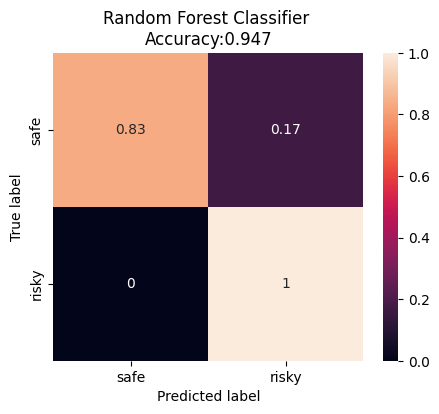

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_df = pd.DataFrame(cm, index=['safe', 'risky'], columns=['safe', 'risky'])

plt.figure(figsize=(5, 4))
sns.heatmap(cm_df, annot=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Random Forest Classifier \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))


Text(0.5, 1.0, 'Variable Importance')

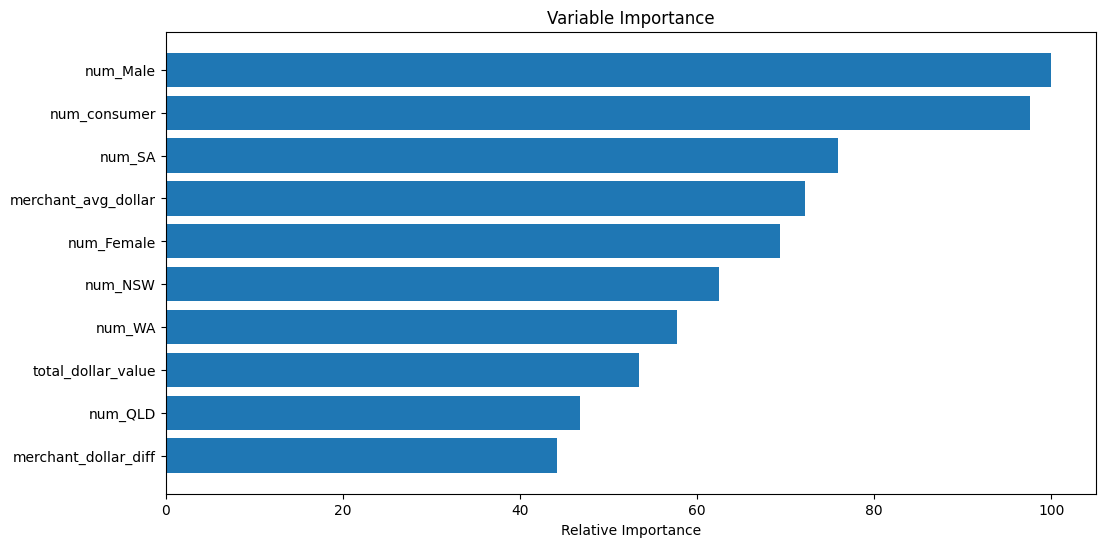

In [27]:
# draw feature importance
feature_importance = rfc.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-10:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')


## 7.3 Predict on whole transaction

In [28]:
# process predict data
# Target encoding merchant_abn on average, std and median dollar amount
merchant_avg_dollar = predict.groupby('merchant_abn')['dollar_value'].mean()
predict['merchant_avg_dollar'] = predict['merchant_abn'].map(merchant_avg_dollar)
merchant_std_dollar = predict.groupby('merchant_abn')['dollar_value'].std()
predict['merchant_std_dollar'] = predict['merchant_abn'].map(merchant_std_dollar)
merchant_mid_dollar = predict.groupby('merchant_abn')['dollar_value'].median()
predict['merchant_mid_dollar'] = predict['merchant_abn'].map(merchant_mid_dollar)
# together with max difference
merchant_dollar_diff = predict.groupby('merchant_abn')['dollar_value'].max() - predict.groupby('merchant_abn')['dollar_value'].min()
predict['merchant_dollar_diff'] = predict['merchant_abn'].map(merchant_dollar_diff)

# if merchant only have one train, set std to 0
predict['merchant_std_dollar'].fillna(0, inplace=True)

# encoding order_datetime to day, month, year
predict['order_datetime'] = pd.to_datetime(predict['order_datetime'])
predict['day'] = predict['order_datetime'].dt.day
predict['month'] = predict['order_datetime'].dt.month
predict['year'] = predict['order_datetime'].dt.year
# drop order_datetime
predict.drop('order_datetime', axis=1, inplace=True)

predict

,user_id,merchant_abn,dollar_value,state,postcode,gender,revenue_level,take_rate,consumer_fraud_probability,risk_level,...,area_telecom,area_tent,area_toy,merchant_avg_dollar,merchant_std_dollar,merchant_mid_dollar,merchant_dollar_diff,day,month,year
0,21989,31334588839,14080.096388,VIC,3818,Undisclosed,1,4.22,fraud,NaN,...,0,0,0,6157.743097,6013.030433,4390.585634,49573.621095,28,2,2021
1,21989,14430838529,74.674454,VIC,3818,Undisclosed,2,2.03,fraud,NaN,...,1,0,0,58.271566,47.144586,46.306093,455.334335,28,2,2021
2,4144,45629217853,3.167339,NSW,2736,Male,0,6.98,safe,NaN,...,0,0,0,36.828331,36.721113,25.597485,504.476920,28,2,2021
3,4351,64203420245,49.474965,NSW,2340,Female,2,2.86,unsure,NaN,...,0,1,0,28.949479,15.025232,28.942648,51.999324,28,2,2021
4,4952,21439773999,76.071035,NSW,1234,Male,0,6.10,safe,NaN,...,1,0,0,78.145058,55.012546,65.712938,563.158321,28,2,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13588848,11135,49891706470,24.174809,NSW,2013,Female,0,5.80,safe,NaN,...,0,1,0,28.973095,15.014905,28.939793,51.999932,26,10,2022
13588849,11136,24852446429,5.384811,QLD,4707,Male,2,2.94,safe,NaN,...,0,0,0,30.046456,21.178621,25.252306,266.757793,26,10,2022
13588850,11136,63685007785,48.129887,QLD,4707,Male,4,0.38,safe,NaN,...,1,0,0,78.436691,54.736140,66.257042,435.920644,26,10,2022
13588851,11137,85502310765,4.768752,VIC,3413,Male,3,0.84,safe,NaN,...,0,0,0,99.676833,99.696983,70.159294,921.505924,26,10,2022


Similar to process for modeling above

In [29]:
predict_by_merchant = pd.DataFrame()

predict_by_merchant['num_consumer'] = predict.groupby('merchant_abn')['user_id'].nunique()
predict_by_merchant['num_transaction'] = predict.groupby('merchant_abn').size()

fraud_group = predict[predict['consumer_fraud_probability'] == 'fraud'].groupby('merchant_abn')
safe_group = predict[predict['consumer_fraud_probability'] == 'safe'].groupby('merchant_abn')
unsure_group = predict[predict['consumer_fraud_probability'] == 'unsure'].groupby('merchant_abn')

predict_by_merchant['num_fraud'] = fraud_group.size()
predict_by_merchant['num_safe'] = safe_group.size()
predict_by_merchant['num_unsure'] = unsure_group.size()

predict_by_merchant['total_dollar_value'] = predict.groupby('merchant_abn')['dollar_value'].sum()

states = predict['state'].unique()
postcodes = predict['postcode'].unique()
genders = predict['gender'].unique()

temp_df = pd.DataFrame()
for state in states:
    state_group = predict[predict['state'] == state].groupby('merchant_abn')
    temp_df[f'num_{state}'] = state_group.size()

for postcode in postcodes:
    postcode_group = predict[predict['postcode'] == postcode].groupby('merchant_abn')
    temp_df[f'num_{postcode}'] = postcode_group.size()

for gender in genders:
    gender_group = predict[predict['gender'] == gender].groupby('merchant_abn')
    temp_df[f'num_{gender}'] = gender_group.size()

predict_by_merchant = pd.concat([predict_by_merchant, temp_df], axis=1)

In [30]:
# get revenue_level, take_rate, area, merchant_avg_dollar, merchant_std_dollar, merchant_mid_dollar, merchant_dollar_diff
predict_by_merchant['revenue_level'] = predict.groupby('merchant_abn')['revenue_level'].first()
predict_by_merchant['take_rate'] = predict.groupby('merchant_abn')['take_rate'].first()
predict_by_merchant['merchant_avg_dollar'] = predict.groupby('merchant_abn')['merchant_avg_dollar'].first()
predict_by_merchant['merchant_std_dollar'] = predict.groupby('merchant_abn')['merchant_std_dollar'].first()
predict_by_merchant['merchant_mid_dollar'] = predict.groupby('merchant_abn')['merchant_mid_dollar'].first()
predict_by_merchant['merchant_dollar_diff'] = predict.groupby('merchant_abn')['merchant_dollar_diff'].first()

predict_by_merchant.reset_index(inplace=True)

predict_by_merchant

,merchant_abn,num_consumer,num_transaction,num_fraud,num_safe,num_unsure,total_dollar_value,num_VIC,num_NSW,num_TAS,...,num_3944,num_Undisclosed,num_Male,num_Female,revenue_level,take_rate,merchant_avg_dollar,merchant_std_dollar,merchant_mid_dollar,merchant_dollar_diff
0,10023283211,3032,3261,8.0,3225.0,28.0,7.032777e+05,754.0,968.0,110.0,...,NaN,329.0,1463.0,1469.0,4,0.18,215.663205,138.039260,185.435023,1302.793469
1,10142254217,2845,3032,4.0,2983.0,45.0,1.183560e+05,743.0,865.0,122.0,...,NaN,310.0,1420.0,1302.0,1,4.22,39.035632,38.288948,26.594722,302.062251
2,10187291046,335,336,NaN,335.0,1.0,3.969373e+04,74.0,90.0,14.0,...,NaN,37.0,152.0,147.0,1,3.29,118.136102,84.308558,95.462517,543.972812
3,10192359162,383,385,NaN,385.0,NaN,1.779805e+05,89.0,108.0,13.0,...,NaN,34.0,182.0,169.0,0,6.33,462.287027,357.567557,384.734897,2303.752029
4,10206519221,7889,9605,12.0,9555.0,38.0,3.582226e+05,2199.0,2698.0,379.0,...,3.0,935.0,4383.0,4287.0,0,6.34,37.295429,36.637812,26.187412,428.218563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3677,99938978285,12385,17443,52.0,17310.0,81.0,5.233000e+05,4041.0,5055.0,622.0,...,4.0,1792.0,7796.0,7855.0,1,4.50,30.000574,30.097605,21.020518,332.595185
3678,99974311662,130,130,NaN,130.0,NaN,3.832013e+04,33.0,38.0,5.0,...,NaN,18.0,54.0,58.0,1,3.17,294.770198,218.923669,235.163538,1197.186851
3679,99976658299,14901,23148,22.0,23084.0,42.0,3.466969e+06,5341.0,6654.0,812.0,...,5.0,2306.0,10583.0,10259.0,0,6.57,149.774024,86.999715,133.484161,668.488113
3680,99987905597,189,191,NaN,191.0,NaN,6.911164e+04,38.0,58.0,7.0,...,NaN,13.0,87.0,91.0,0,6.82,361.841071,225.000119,333.589098,1619.204095


In [31]:
# get all column named "area_<> from transaction into predict_by_merchant
for col in transaction.columns:
    if 'area_' in col:
        predict_by_merchant[col] = predict.groupby('merchant_abn')[col].first()

In [32]:
# keep merchant_abn
predict_merchant_abn = predict_by_merchant['merchant_abn']
predict_by_merchant.drop('merchant_abn', axis=1, inplace=True)

In [33]:
predict_by_merchant.fillna(0, inplace=True)
predict_by_merchant

,num_consumer,num_transaction,num_fraud,num_safe,num_unsure,total_dollar_value,num_VIC,num_NSW,num_TAS,num_WA,...,area_housekeeping,area_jewelry,area_motor,area_music,area_optician,area_shoe,area_stationery,area_telecom,area_tent,area_toy
0,3032,3261,8.0,3225.0,28.0,7.032777e+05,754.0,968.0,110.0,517.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2845,3032,4.0,2983.0,45.0,1.183560e+05,743.0,865.0,122.0,481.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,335,336,0.0,335.0,1.0,3.969373e+04,74.0,90.0,14.0,51.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,383,385,0.0,385.0,0.0,1.779805e+05,89.0,108.0,13.0,62.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7889,9605,12.0,9555.0,38.0,3.582226e+05,2199.0,2698.0,379.0,1493.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3677,12385,17443,52.0,17310.0,81.0,5.233000e+05,4041.0,5055.0,622.0,2741.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3678,130,130,0.0,130.0,0.0,3.832013e+04,33.0,38.0,5.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3679,14901,23148,22.0,23084.0,42.0,3.466969e+06,5341.0,6654.0,812.0,3680.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3680,189,191,0.0,191.0,0.0,6.911164e+04,38.0,58.0,7.0,27.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
X_test

,num_consumer,num_transaction,num_fraud,num_safe,num_unsure,total_dollar_value,num_VIC,num_NSW,num_TAS,num_WA,...,area_housekeeping,area_jewelry,area_motor,area_music,area_optician,area_shoe,area_stationery,area_telecom,area_tent,area_toy
39,52,52,21.0,21.0,10.0,243133.609118,13.0,13.0,2.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,1,1,1.0,0.0,0.0,41689.730399,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,209,209,0.0,208.0,1.0,43798.591647,46.0,64.0,6.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,2,2,2.0,0.0,0.0,57813.051216,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,5,5.0,0.0,0.0,137660.711788,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,3,3,3.0,0.0,0.0,134108.925291,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,4,4,0.0,4.0,0.0,1531.697541,2.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,148,149,4.0,144.0,1.0,45932.684592,31.0,36.0,9.0,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,157,158,0.0,157.0,1.0,86391.848352,38.0,45.0,6.0,28.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45,1,1,1.0,0.0,0.0,44615.022521,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# make sure predict data has same column order as X_test
predict_by_merchant = predict_by_merchant[X_test.columns]
predict_by_merchant

,num_consumer,num_transaction,num_fraud,num_safe,num_unsure,total_dollar_value,num_VIC,num_NSW,num_TAS,num_WA,...,area_housekeeping,area_jewelry,area_motor,area_music,area_optician,area_shoe,area_stationery,area_telecom,area_tent,area_toy
0,3032,3261,8.0,3225.0,28.0,7.032777e+05,754.0,968.0,110.0,517.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2845,3032,4.0,2983.0,45.0,1.183560e+05,743.0,865.0,122.0,481.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,335,336,0.0,335.0,1.0,3.969373e+04,74.0,90.0,14.0,51.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,383,385,0.0,385.0,0.0,1.779805e+05,89.0,108.0,13.0,62.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7889,9605,12.0,9555.0,38.0,3.582226e+05,2199.0,2698.0,379.0,1493.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3677,12385,17443,52.0,17310.0,81.0,5.233000e+05,4041.0,5055.0,622.0,2741.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3678,130,130,0.0,130.0,0.0,3.832013e+04,33.0,38.0,5.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3679,14901,23148,22.0,23084.0,42.0,3.466969e+06,5341.0,6654.0,812.0,3680.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3680,189,191,0.0,191.0,0.0,6.911164e+04,38.0,58.0,7.0,27.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# predict
predict_by_merchant['risk_level'] = rfc.predict(predict_by_merchant)

In [37]:
# check prediction label count
pd.Series(predict_by_merchant['risk_level']).value_counts()

1.0    3147
2.0     535
Name: risk_level, dtype: int64

In [38]:
# write a csv only has merchant_abn and corresponding risk_level
predict_result = pd.concat([predict_merchant_abn, predict_by_merchant['risk_level']], axis=1)

# check label count
print(predict_result['risk_level'].value_counts())

# write to csv as final outcome
predict_result.to_csv('../data/curated/merchant/merchant_risk_level.csv', index=False)

1.0    3147
2.0     535
Name: risk_level, dtype: int64
